In [346]:
import numpy as np
import random
from dataclasses import dataclass
import matplotlib.pyplot as plt
import gym
import torch
import torch.nn.functional as F

In [330]:
env = gym.make('FrozenLake-v1', is_slippery=False)

In [331]:
nS = env.observation_space.n
nA = env.action_space.n

In [358]:
gamma = 0.9
alpha = 0.01
eps = 1.0
eps_decay = 0.9999999
batch_size = 64

In [359]:
max_episodes = 1000000
max_steps = 40

In [360]:
def select_action(net, s, epsilon):
    with torch.no_grad():
        if np.random.rand() < epsilon:
            return np.random.choice(nA)
        f = F.one_hot(torch.tensor([s]), nS).float()
        return qnet(f).argmax().item()

In [361]:
qnet = torch.nn.Sequential(
    torch.nn.Linear(nS, 10),
    torch.nn.ReLU(),
    torch.nn.Linear(10, nA)
)

In [362]:
opt = torch.optim.Adam(net.parameters(), alpha)

In [363]:
torch.nn.functional.one_hot(torch.tensor([0]), 10)

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [364]:
@dataclass
class Transition:
    state: int
    action: int
    next_state: int
    reward: float

class ReplayBuffer(object):
    def __init__(self, size):
        self._storage = []
        self._maxsize = size
        self._next_idx = 0

    def __len__(self):
        return len(self._storage)

    def push(self, *args):
        data = Transition(*args)

        if self._next_idx >= len(self._storage):
            self._storage.append(data)
        else:
            self._storage[self._next_idx] = data
        self._next_idx = (self._next_idx + 1) % self._maxsize

    def sample_batch(self, batch_size):
        return [self._storage[random.randint(0, len(self._storage) - 1)] for _ in range(batch_size)]

In [365]:
env.step(2)

(7, 0, True, False, {'prob': 1.0})

In [366]:
Rs = []
Eps = []
buffer = ReplayBuffer(1000)
for episode in range(max_episodes):
    s, _ = env.reset()
    R = 0
    for step in range(max_steps):
        a = select_action(net, s, eps)
        s_prime, r, done, _, _ = env.step(a)
        buffer.push(s, a, s_prime, r)
        R += r

        if done:
            break
            
        s = s_prime
        eps *= eps_decay
    Rs.append(R)
    Eps.append(eps)
    
    sample = buffer.sample_batch(batch_size)
    s = torch.tensor([t.state for t in sample])
    s_prime = torch.tensor([t.next_state for t in sample])
    a = torch.tensor([t.action for t in sample])
    r = torch.tensor([t.reward for t in sample])
    
    f = F.one_hot(s, nS).float()
    f_prime = F.one_hot(s_prime, nS).float()
            
    opt.zero_grad()
    q = qnet(f)[:, a]
    q_prime = qnet(f_prime).max(dim=1).values
    loss = (r + gamma*q_prime - q).pow(2).mean()
    loss.backward()
    opt.step()

In [352]:
net(fs_prime).max(dim=1).values

tensor([0.0023, 0.0023, 0.0023, 0.0023, 0.0023, 0.0023, 0.0023, 0.0023, 0.0023,
        0.0023, 0.0023], grad_fn=<MaxBackward0>)

In [353]:
(rs + gamma*q_prime - q).pow(2)

RuntimeError: The size of tensor a (11) must match the size of tensor b (64) at non-singleton dimension 0

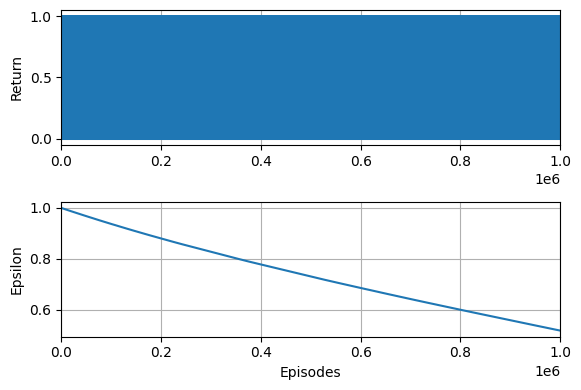

In [367]:
fig, axes = plt.subplots(2, 1, figsize=(6, 4))
axes = axes.flatten()
axes[0].plot(Rs)
axes[0].set_xlim(0, max_episodes)
axes[0].grid()
axes[0].set_ylabel("Return")
axes[1].plot(Eps)
axes[1].set_xlim(0, max_episodes)
axes[1].grid()
axes[1].set_xlabel("Episodes")
axes[1].set_ylabel("Epsilon")
plt.tight_layout()
plt.show()

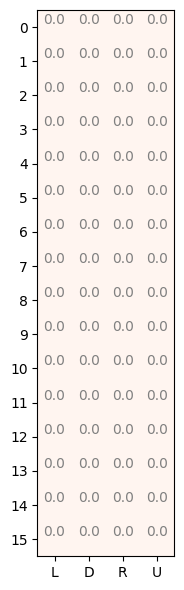

In [82]:
plt.figure(figsize=(16, 6))
plt.imshow(Q, cmap='Reds')
for i in range(nS):
    for j in range(nA):
        q = np.around(Q[i, j], 2)
        plt.text(j, i, q, ha='center', va='bottom', color='gray')
plt.yticks(np.arange(nS), np.arange(nS))
plt.xticks(np.arange(nA), ['L', 'D', 'R', 'U'])
plt.tight_layout()
plt.show()